# Sobreajuste, generalización y subajuste

En el notebook anterior presentamos el framework de la validación cruzada y cómo esta nos ayuda a cuantificar los errores de entrenamiento y de prueba, así como sus fluctuaciones.

En este notebook, pondremos estos dos errores en perspectiva y mostraremos cómo pueden ayudarnos a determinar si nuestro modelo generaliza, sobreajusta (overfit) o subajusta (underfit).


Primero, carguemos los datos y visualicemos los valores de las características y del objetivo.

In [1]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target
target *= 100  # rescale the target in k$

In [2]:
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [3]:
target.head()

,MedHouseVal
0,452.6
1,358.5
2,352.1
3,341.3
4,342.2


Como modelo usaremos un árbol de decisión.

In [4]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()

## Sobreajuste vs. subajuste

Para comprender mejor el rendimiento de generalización de nuestro modelo y, quizás obtener información sobre cómo mejorarlo, compararemos el error del conjunto de prueba con el error del conjunto de entrenamiento.

Para ello, necesitamos calcular el error en el conjunto de entrenamiento, lo cual es posible utilizando la función `cross_validate`.

In [5]:
import pandas as pd
from sklearn.model_selection import cross_validate, ShuffleSplit

cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=0)
cv_results = cross_validate(regressor,data,target,cv=cv,scoring="neg_mean_absolute_error",return_train_score=True,n_jobs=2)
cv_results = pd.DataFrame(cv_results)

Recuerda que cross-validation usa el negativo del error absoluto medio, por tal motivo transformamos a positivo ese error.

In [6]:
scores = pd.DataFrame()
scores[["train error", "test error"]] = -cv_results[["train_score", "test_score"]]
scores.head()

,train error,test error
0,1.526083e-14,46.777536
1,3.277310e-15,46.542294
2,9.284563e-15,44.104959
3,3.294522e-15,43.242093
4,8.833588e-15,47.924633


Ahora graficamos el error de entrenamiento y prueba utilizando un histograma.

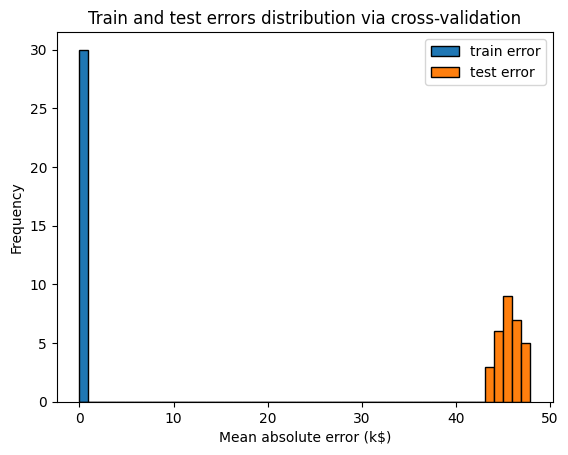

In [7]:
import matplotlib.pyplot as plt

scores.plot.hist(bins=50, edgecolor="black")
plt.xlabel("Mean absolute error (k$)")
plt.title("Train and test errors distribution via cross-validation")
plt.show()

Al graficar la distribución de los errores de entrenamiento y de prueba, obtenemos información sobre si nuestro modelo está sobreajustando o subajustando.

En este caso, observamos un **error de entrenamiento muy pequeño** (de hecho, igual a cero), lo que significa que **el modelo no está subajustando**: es lo suficientemente flexible para capturar todas las variaciones presentes en el conjunto de entrenamiento.

Sin embargo, **el error de prueba significativamente mayor** nos indica que **el modelo está sobreajustando**: ha memorizado muchas variaciones del conjunto de entrenamiento que podrían considerarse “ruido”, ya que no generalizan ni ayudan a hacer buenas predicciones en el conjunto de prueba.


## Curva de validación

Llamamos hiperparámetros a aquellos parámetros que pueden influir en el resultado del aprendizaje y en las predicciones de un modelo. Por ejemplo:


*   el número de vecinos en un modelo k-nearest neighbors (k-NN)
*   el grado del polinomio en un modelo polinomial


Algunos hiperparámetros son clave para pasar de un modelo que subajusta a uno que sobreajusta, con la esperanza de encontrar un punto intermedio donde se logre un buen equilibrio entre ambos extremos.

Podemos obtener esta información mediante una gráfica llamada curva de validación, que muestra cómo varía el rendimiento del modelo según los distintos valores de un hiperparámetro.

En el caso del árbol de decisión, el hiperparámetro max_depth se utiliza para controlar el equilibrio entre subajuste y sobreajuste.

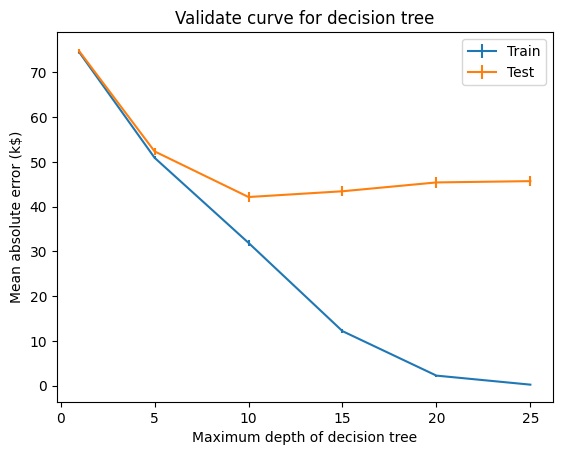

CPU times: user 736 ms, sys: 84.6 ms, total: 820 ms
Wall time: 36.7 s


In [8]:
%%time
import numpy as np
from sklearn.model_selection import ValidationCurveDisplay

max_depth = np.array([1, 5, 10, 15, 20, 25])
disp = ValidationCurveDisplay.from_estimator(regressor,data,target,param_name="max_depth",param_range=max_depth,cv=cv,
                                             scoring="neg_mean_absolute_error",negate_score=True,std_display_style='errorbar',n_jobs=2)
disp.ax_.set(xlabel="Maximum depth of decision tree",ylabel="Mean absolute error (k$)",title="Validate curve for decision tree")
plt.show()

La curva de validación puede dividirse en tres zonas:

1.   Para `max_depth < 10`, el árbol de decisión presenta subajuste (underfitting). Tanto el error de entrenamiento como el error de prueba son altos. El modelo está demasiado limitado y no logra capturar gran parte de la variabilidad de la variable objetivo.
2.   La región alrededor de `max_depth = 10` corresponde al valor del hiperparámetro donde el árbol generaliza mejor. Es lo suficientemente flexible para capturar una parte significativa de la variabilidad de la variable objetivo que sí generaliza, sin memorizar el ruido presente en los datos.
3.   Para `max_depth > 10`, el árbol de decisión sobreajusta (overfitting).
El error de entrenamiento se vuelve muy pequeño, mientras que el error de prueba aumenta. En esta región, el modelo crea decisiones demasiado específicas para las muestras ruidosas, lo que perjudica su capacidad de generalizar a nuevos datos.










Es importante tener en cuenta que analizar solo los errores medios es limitado.
También debemos observar la desviación estándar para evaluar la dispersión de las puntuaciones.
Para ello, se puede utilizar el parámetro `std_display_style`, que permite visualizar la desviación estándar de los errores.

En este caso, la varianza de los errores es pequeña en comparación con sus valores respectivos, por lo que las conclusiones anteriores son claras.
No obstante, esto no siempre ocurre así en todos los casos.

Cabe notar que, para `max_depth = 10`, el modelo todavía sobreajusta ligeramente, ya que existe una brecha entre el error de entrenamiento y el de prueba.
También podría subajustar un poco al mismo tiempo, porque el error de entrenamiento aún está lejos de ser cero (más de 30 k$), lo que indica que el modelo podría estar algo restringido para representar ciertos patrones interesantes de los datos.
Sin embargo, el error de prueba no es muy grande, y esto es lo que realmente importa: este es el mejor compromiso que se puede alcanzar ajustando únicamente este parámetro.

Ahora, configuremos el hiperparámetro `max_depth = 10` y volvamos a entrenar el modelo.

In [9]:
regressor.set_params(max_depth=10)
cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=0)
cv_results = cross_validate(regressor,data,target,cv=cv,scoring="neg_mean_absolute_error",return_train_score=True,n_jobs=2)
cv_results = pd.DataFrame(cv_results)
scores = pd.DataFrame()
scores[["train error", "test error"]] = -cv_results[["train_score", "test_score"]]

Grafiquemos los errores de entrenamiento y prueba con el nuevo valor del hiperparámetro.

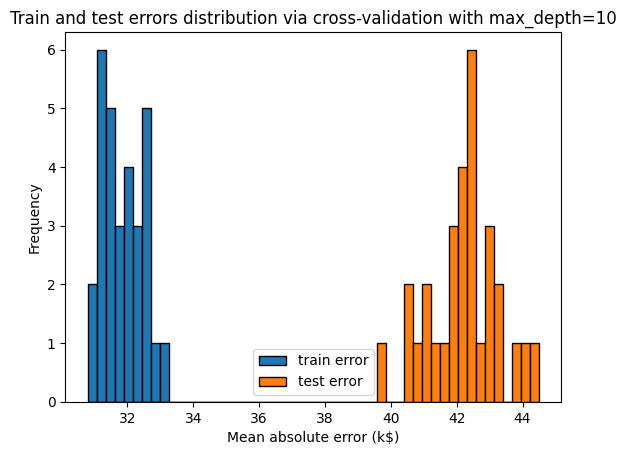

In [10]:
scores.plot.hist(bins=50, edgecolor="black")
plt.xlabel("Mean absolute error (k$)")
plt.title("Train and test errors distribution via cross-validation with max_depth=10")
plt.show()

Del gráfico anterior observamos que ahora el error de entranamiento ya no es cero y se acerca más al error de prueba, lo cual indica un mejor equilibrio entre el sobreajuste y el subajuste del modelo.

## Resumen:

En este notebook vimos:

* Cómo identificar si un modelo está generalizando, presenta sobreajuste o subajuste
* Cómo revisar la influencia que tiene un hiperparámetro en el compromiso entre sobreajuste y subajuste de un modelo